# Using PyMC3 to fit Gaussian curves to photopeaks in a gamma-ray spectrum

A gamma-ray spectrum (GRS) is a histogram describing the counts of detected photons as a function of photon energy. GRS can be useful when evaluating the dosage received from a sample containing unknown radioisotopes. To do this, the total counts produced above background by a source has to be calculated. 

Above the background level, a gamma source produces sharp peaks, called "photopeaks", due to discrete energy level changes in a nucleus. A method for finding the total counts is to fit a curve to every photopeak in a GRS, and integrate each one to find the total area contained under photopeaks.

In this example, I'll use MCMC to fit Gaussian curves to peaks found in gamma-ray spectrum of a sample of Ba-133.

### Useful imports:

In [1]:
# numpy
import numpy as np

# scipy
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
from scipy import integrate

# Plotting
import corner

import matplotlib.pyplot as plt
%matplotlib inline

# Sampler
import pymc3 as pm
print('PyMC3 version: {}'.format(pm.__version__))

# misc
import logging
from time import time

PyMC3 version: 3.9.2


### Viewing the data:

The data is in the form of a histogram with over 16000 bins, each with width of one "MCA-Channel". This unit of energy is specific to the detector used to collect the GRS, and so we also must calibrate the spectrum to have a bin width in keV.

Start by loading in both the calibration parameters, and the entire gamma-ray spectrum as a list:

In [2]:
#Load detector calibration
cali_dir = "calibration.txt"
with open(cali_dir, "r") as file:
    calibration = file.read().splitlines()
calibration = list(map(float, calibration))
c_0 = calibration[0]
c_2 = calibration[2]

#Load gamma-ray spectrum data
spectra_dir = "Ba.TKA"
with open(spectra_dir, "r") as file:
    counts = [int(j) for j in file]
counts = counts[2:]

The spectrum contains an X-ray region at lower energies, and an extremely noisy region at higher energies. Both of these regions are not very useful for this demonstration, so I'll only show the section I'll be searching for photopeaks.

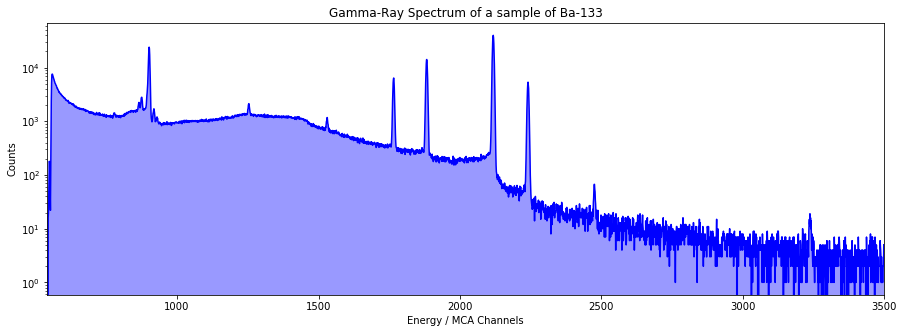

In [3]:
xrange = np.array(range(len(counts)))  # Bins for gamma-ray spectrum

# Plot the spectrum
plt.figure(figsize=(15,5))
plt.plot(xrange, counts, "b")
plt.fill(xrange, counts, "b", alpha= 0.4)
plt.xlabel("Energy / MCA Channels")
plt.ylabel("Counts")
plt.title("Gamma-Ray Spectrum of a sample of Ba-133")
plt.yscale("log")
plt.xlim(540, 3500)
plt.show()

The spectrum is made up of a smooth background counts curve, with sharp peaks sitting on top. These are the photopeaks we're searching for.
Using scipy's "find_peaks" function, we can select some photopeaks in the spectrum to analyse. This function looks for local maxima by comparing a point to it's neighbours. The optional arguments specify the minimum height for a peak to be returned, and a "neighbourhood width", so only the largest peak in a given neighbourhood will be returned. 

In [4]:
# Find prominent peaks in data using scipy
peaks = find_peaks(counts, height=1300, distance=100)[0][3:]

This function returns the indicies at which a peak maximum is located in the gamma-ray spectrum. Next, I'll define a "radius" of 20 bins around each peak centre, and create lists containing the data for each peak. 

Lets plot each peak to see what the function found:

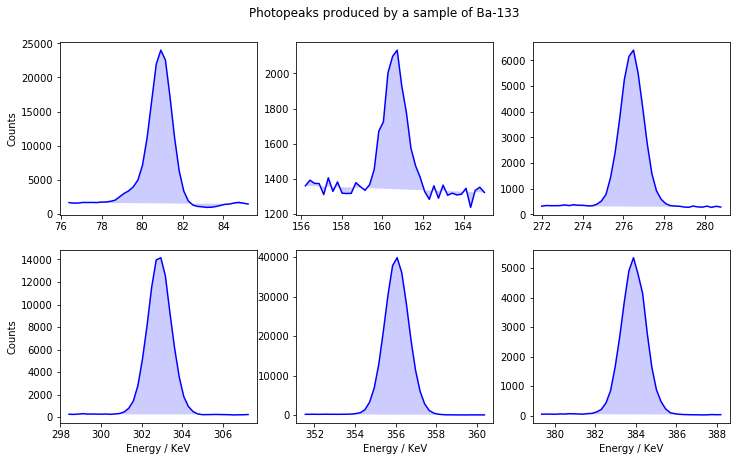

In [5]:
# select an area around peak to be plotted & calibrate energy scale to keV 
ranger = 20
peaks_x = [c_0*np.array(range(peak-ranger, peak+ranger)) + c_2 for peak in peaks]
peaks_y = [counts[peak-ranger:peak+ranger] for peak in peaks]

# Plot selected peaks from gamma-ray spectrum
fig, axs = plt.subplots(2,3, figsize=(12,7))
for i in range(2):
    for j in range(3):
        ind = 3*i + j
        axs[i,j].plot(peaks_x[ind], peaks_y[ind], "b")
        axs[i, j].fill(peaks_x[ind], peaks_y[ind], "b", alpha=0.2)
        if i == 1:
            axs[i,j].set_xlabel("Energy / KeV")
        if j == 0:
            axs[i,j].set_ylabel("Counts")
fig.suptitle("Photopeaks produced by a sample of Ba-133", y=0.95)
plt.show()

### Sampling the data:

The decays that cause the photopeaks in a GRS have a descrete energy. The width of the photopeaks is caused by imperfections in the detector crystal, such as defects or excess thermal energy. This causes each peak to have a Gaussian nature, rather than a sharp peak.

I'll attempt to fit a Gaussian curve to each peak, by first defining the Gaussian fuction to be used:

In [6]:
def gauss(x, a, xc, w, y0):
    """
    Gaussian function
    :param x: 1D array of input points
    :param a: Amplitude of peak
    :param xc: Mean peak energy
    :param w: Standard deviation of peak
    :param y0: Background counts under peak
    :return: 1D array of Gaussian output points
    """
    return a*np.exp(-(x-xc)**2/(2*w**2))+y0

Our goal is to find the values of the parameters above that best explain each photopeak. To ensure that the algorithms quickly converge on the most likely parameter values, I'll guess some values for the parameters of each peak, simply by using the plots above. Since the standard deviation appears roughly the same for all the peaks, I won't use an individual guess for each peak.

In [7]:
#initialise a model for each peak, and define guesses for the parameters
gauss_models = [pm.Model() for i in range(len(peaks))]
a_guesses = [23000., 900., 6100., 13800., 39800., 5300.]
xc_guesses = [81., 161., 276.5, 303., 356., 384.]
y0_guesses = [1700., 1350., 300., 300., 250., 50.]

Next, I'll use the above guesses to initialise each model. PyMC3 requires the used to provide a prior for each parameter, and a likelihood function, which can be easily set using the in-built Normal and Poisson probabillity distribution functions. 

This is done within the scope of each model defined above, using the "with" statement:

In [8]:
for i in range(len(peaks)):
    with gauss_models[i]:
        # set prior parameters
        # amplitude
        a_mu = a_guesses[i]     # mean of amplitude of peaks
        a_sig = 100.            # standard deviation of amplitude of peaks

        # peak energy
        xc_mu = xc_guesses[i]  # mean of peak energy
        xc_sig = 1.            # standard deviation of peak energy

        # standard deviation
        w_mu = 1.2             # mean of peak standard deviation
        w_sig = 1.             # standard deviation of peak standard deviation

        # background counts
        y0_mu = y0_guesses[i]  # mean of background counts
        y0_sig = 30.           # standard deviation of background counts

        # set normal priors
        a_model = pm.Normal('Amplitude', mu=a_mu, sd=a_sig) 
        xc_model = pm.Normal('Peak Energy', mu=xc_mu, sd=xc_sig)  
        w_model = pm.Normal('Standard Deviation', mu=w_mu, sd=w_sig)  
        y0_model = pm.Normal('Background Counts', mu=y0_mu, sd=y0_sig)
        
        # Expected value of outcome
        mu = gauss(peaks_x[i], a_model, xc_model, w_model, y0_model)

        # Poisson likelihood of observations
        Y_obs = pm.Poisson('Y_obs', mu=mu, observed=peaks_y[i])

Now each model has been initialised, the MCMC sampling algorithm can now be applied. PyMC3 uses a set of samples, as well as a set of tuning samples. We can also use the "time" package to record how long it took to sample all of the photopeaks.

In [9]:
Nsamples = 800 # number of samples
Ntune = 1000    # number of tuning samples

# disable PyMC3 console logs, for neatness
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

# perform sampling
traces = []
t0 = time()
for i in range(len(peaks)):
    with gauss_models[i]:
        traces.append(pm.sample(Nsamples, tune=Ntune, discard_tuned_samples=True))
t1 = time()

timepymc3 = t1-t0  # time taken to sample all of the photopeaks

print("{} seconds ({} seconds per peak) taken to run PyMC3 sampling.".format(timepymc3, timepymc3/6))

339.7628481388092 seconds (56.6271413564682 seconds per peak) taken to run PyMC3 sampling.


### Alternate Sampling Method:

The above method uses a Poisson likelihood, since a metric like counts is non-negative. Although, since the peaks in the gamma-ray spectrum have large enough amplitudes, the likelihood can be well approximated by a normal distribution, with a estimate for the noise standard deviation. Guessing this standard deviation value is tricky, so instead we can set it as an extra parameter for the sampler. A good prior to start with is a uniform probabillity distribution in log-space, meaning the standard deviation has an equal probabillity of having any order of magnitude between an upper and lower bound.

I'll showcase this method, but I'll use the previous method for the results section below. I'll also use only the 2nd peak found, as it has the noisiest data and will likely produce the most interesting results. Start by initiating a new set of models using simillar code as before, but with the new likelihood.

In [10]:
gauss_model_alt = pm.Model()
with gauss_model_alt:
    # set prior parameters
    # amplitude
    a_mu = a_guesses[1]    # mean of amplitude of peaks
    a_sig = 50.            # standard deviation of amplitude of peaks
        
    # peak energy
    xc_mu = xc_guesses[1]  # mean of peak energy
    xc_sig = 1.            # standard deviation of peak energy
        
    # standard deviation
    w_mu = 1.2             # mean of peak standard deviation
    w_sig = 1.             # standard deviation of peak standard deviation
        
    # background counts
    y0_mu = y0_guesses[1]  # mean of background counts
    y0_sig = 30.           # standard deviation of background counts
        
    # noise deviation
    sigma_min = -1         # minimum order of magnitude of the noise deviation
    sigma_max = 2          # maximum order of magnitude of the noise deviation
        
    # set normal priors
    a_model = pm.Normal('Amplitude', mu=a_mu, sd=a_sig)
    xc_model = pm.Normal('Peak Energy', mu=xc_mu, sd=xc_sig)
    w_model = pm.Normal('Standard Deviation', mu=w_mu, sd=w_sig)
    y0_model = pm.Normal('Background Counts', mu=y0_mu, sd=y0_sig)
    # set uniform prior
    sigma_model = pm.Uniform('Noise', lower=sigma_min, upper=sigma_max)
        
    # Expected value of outcome
    mu = gauss(peaks_x[1], a_model, xc_model, w_model, y0_model)
    # Normal likelihood of observations with noise
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=10 ** sigma_model, observed=peaks_y[1])

Performing the sampling again gives our alternate posteriors:

In [11]:
Nsamples = 800
Ntune = 1000

# perform sampling
t0_alt = time()
with gauss_model_alt:
    trace_alt = pm.sample(Nsamples, tune=Ntune, discard_tuned_samples=True)
t1_alt = time()

timepymc3_alt = t1_alt-t0_alt

print("{} seconds taken to run PyMC3 alternate sampling.".format(timepymc3_alt))

51.17257046699524 seconds taken to run PyMC3 alternate sampling.


We can now briefly use the trace to see what values the sampler converged on for each parameter. I'll return to these values later when finding the uncertainty of the counts under the photopeak.

In [12]:
# collect samples of each parameter
samples_alt = np.vstack((trace_alt['Amplitude'],
                         trace_alt['Peak Energy'],
                         trace_alt['Standard Deviation'],
                         trace_alt['Background Counts'],
                         trace_alt['Noise'])).T

# mean and standard deviation error of each parameter
a_alt, a_err_alt = np.mean(samples_alt[:,0]), np.std(samples_alt[:,0])
xc_alt, xc_err_alt = np.mean(samples_alt[:,1]), np.std(samples_alt[:,1])
w_alt, w_err_alt = np.mean(samples_alt[:,2]), np.std(samples_alt[:,2])
y0_alt, y0_err_alt = np.mean(samples_alt[:,3]), np.std(samples_alt[:,3])
sigma_alt, sigma_err_alt = np.mean(samples_alt[:,4]), np.std(samples_alt[:,4])

# print values
print("Parameter mean values with uncertainties for a photopeak in a sample of Ba-133: \n" + " \n " +
      "            Amplitude = {} \u00B1 {} counts \n".format(a_alt, a_err_alt) +
      "           Peak Energy = {} \u00B1 {} keV \n".format(xc_alt, xc_err_alt) +
      "    Standard Deviation = {} \u00B1 {} keV \n".format(w_alt, w_err_alt) +
      "     Background Counts = {} \u00B1 {} counts \n".format(y0_alt, y0_err_alt) +
      "                 Noise = {} \u00B1 {} counts".format(sigma_alt, sigma_err_alt))

Parameter mean values with uncertainties for a photopeak in a sample of Ba-133: 
 
             Amplitude = 805.8525680535927 ± 22.08710291790741 counts 
           Peak Energy = 160.6048453513323 ± 0.018734413037742755 keV 
    Standard Deviation = 0.5231050243045618 ± 0.018581959237709396 keV 
     Background Counts = 1333.7737653611525 ± 7.029355674835281 counts 
                 Noise = 1.5871267706541523 ± 0.05180381289280473 counts


### Results:

Now that the data has been sampled, we can collect the information for each parameter posterior using the traces. By using a dictionary, we can also collect the mean and standard deviation for each parameter, which will be useful later for plotting the fitted curves.

In [13]:
# collect traces of each parameter from each peak
all_pymc3_samples = [np.vstack((trace['Amplitude'],
                                trace['Peak Energy'],
                                trace['Standard Deviation'],
                                trace['Background Counts'])).T for trace in traces]

# dictionaries to contain mean and standard deviation of each peak
resdict = [{} for i in range(len(peaks))]
for ind in range(len(peaks)):
    resdict[ind]['a_mu'] = np.mean(all_pymc3_samples[ind][:, 0])
    resdict[ind]['a_sig'] = np.std(all_pymc3_samples[ind][:, 0])
    resdict[ind]['xc_mu'] = np.mean(all_pymc3_samples[ind][:, 1])
    resdict[ind]['xc_sig'] = np.std(all_pymc3_samples[ind][:, 1])
    resdict[ind]['w_mu'] = np.mean(all_pymc3_samples[ind][:, 2])
    resdict[ind]['w_sig'] = np.std(all_pymc3_samples[ind][:, 2])
    resdict[ind]['y0_mu'] = np.mean(all_pymc3_samples[ind][:, 3])
    resdict[ind]['y0_sig'] = np.std(all_pymc3_samples[ind][:, 3])

To visualise the information given for each parameter, we can define a function to plot the parameter posteriors, and also create contour plots that describe how any two parameters might depend on each other. This is done using "corner.py". 

As an example, I'll use the 2nd peak again due to its noisy data: 

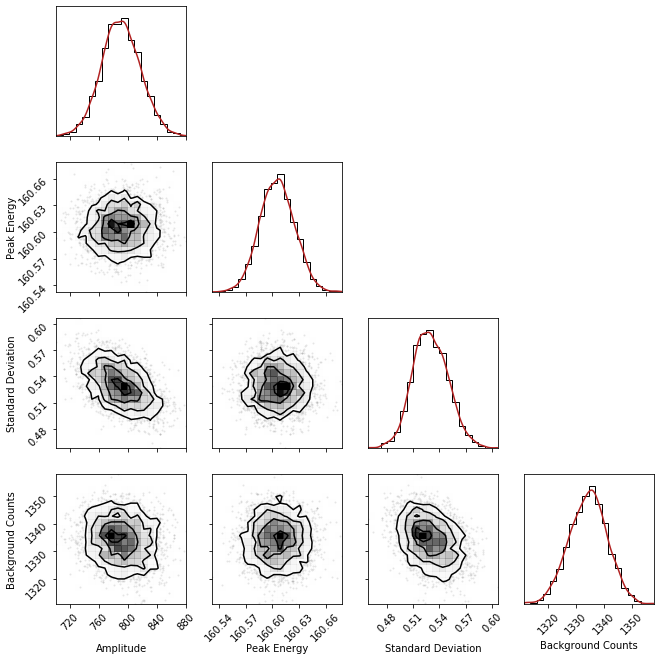

In [14]:
def plotposts(samples, labels, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """

    fig = corner.corner(samples, labels=labels, hist_kwargs={'density': True}, **kwargs)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 5, 10, 15], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color="firebrick")

# create corner plot for peak with noisiest data 
labels = [r"Amplitude", r"Peak Energy", r"Standard Deviation", r"Background Counts"]
corner_plot_samples = all_pymc3_samples[1]

plotposts(corner_plot_samples, labels)

This corner plot shows that the amplitude of a photopeak and its standard deviation are dependant, since their contour plot is not symmetric.

Now that we have the parameter posteriors, along with their means and standard deviations, we can state the most likely value of each parameter, with their uncertainties:

In [15]:
a, a_err = resdict[1]["a_mu"], resdict[1]["a_sig"]
xc, xc_err = resdict[1]["xc_mu"], resdict[1]["xc_sig"]
w, w_err = resdict[1]["w_mu"], resdict[1]["w_sig"]
y0, y0_err = resdict[1]["y0_mu"], resdict[1]["y0_sig"]

print("Parameter mean values with uncertainties for a photopeak in a sample of Ba-133: \n" + " \n " +
      "            Amplitude = {} \u00B1 {} counts \n".format(a, a_err) +
      "           Peak Energy = {} \u00B1 {} keV \n".format(xc, xc_err) +
      "    Standard Deviation = {} \u00B1 {} keV \n".format(w, w_err) +
      "     Background Counts = {} \u00B1 {} counts \n".format(y0, y0_err))

Parameter mean values with uncertainties for a photopeak in a sample of Ba-133: 
 
             Amplitude = 790.8230085052716 ± 26.678217073281974 counts 
           Peak Energy = 160.60563117585673 ± 0.019520210212076124 keV 
    Standard Deviation = 0.5298149405044772 ± 0.019932980751173522 keV 
     Background Counts = 1334.3167756051396 ± 6.738653804789527 counts 



Using the mean values for each parameter, we can define a Gaussian curve for each peak. Plotting this curve over the original data gives the best fit curve for that data. This best fit can be integrated, and by summing the integrals for each peak, the total counts of the gamma-ray spectrum can be found.

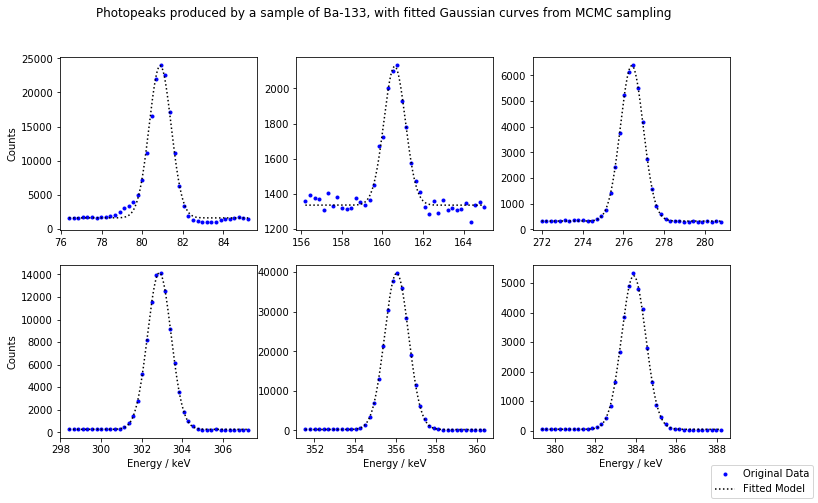

In [16]:
# plot each peak, with the fitted Gaussians superimposed
fig, axs = plt.subplots(2, 3, figsize=(12, 7))
for i in range(2):
    for j in range(3):
        ind = 3 * i + j
        
        a = resdict[ind]["a_mu"]
        xc = resdict[ind]["xc_mu"]
        w = resdict[ind]["w_mu"]
        y0 = resdict[ind]["y0_mu"]
        
        x = peaks_x[ind]
        y = peaks_y[ind]
        
        # plot original data
        axs[i, j].plot(x, y, "b.", 
                       alpha=1, 
                       label=("Original Data" if all(num == 0 for num in [i,j]) else ""))
        
        # plot fitted curve over the data
        xsmooth = np.linspace(x[0], x[-1], len(x) * 100)
        axs[i, j].plot(xsmooth, gauss(xsmooth, a, xc, w, y0), "k:",
                       alpha=1,
                       label=("Fitted Model" if all(num == 0 for num in [i,j]) else ""))

        if i == 1:
            axs[i, j].set_xlabel("Energy / keV")
        if j == 0:
            axs[i, j].set_ylabel("Counts")
leg = fig.legend(loc="lower right", numpoints=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
fig.suptitle("Photopeaks produced by a sample of Ba-133, with fitted Gaussian curves from MCMC sampling")
plt.show()

### Making a Posterior Predictive Plot:

Alternatively, instead of using the means of the parameters to plot the fitted curve, we can use the posterior distributions to randomly sample predictions of each parameter. We can then overplot multiple curves onto the data set. This is useful as instead of only showing the most likely model, it visualises the overall uncertainty of the fit.

Again, I'll use the noisiest peak as an example. First, randomly choose 300 of each parameter from their posteriors:

In [17]:
# number of curves to plot per peak
n_fits = 300
a_samps, xc_samps, w_samps, y0_samps = ([] for i in range(4))
for ind in range(len(peaks)):
    a_samps.append(np.random.choice(all_pymc3_samples[ind][:, 0], size=n_fits))
    xc_samps.append(np.random.choice(all_pymc3_samples[ind][:, 1], size=n_fits))
    w_samps.append(np.random.choice(all_pymc3_samples[ind][:, 2], size=n_fits))
    y0_samps.append(np.random.choice(all_pymc3_samples[ind][:, 3], size=n_fits))

We now have 300 sets of potential parammeters. For each set of parameters, define and overplot a Gaussian curve as before, each curve being slightly different. In regions of the plot where a lot of curves overlap, the plot will appear darker relative to regions with fewer curves. The resulting plots show the regions where a fitted curve is more likely to fall. This is called a posterior predictive plot.

The plot below shows the posterior predictive distribution for the noisiest photopeak. I also included a second plot, which shows a "zoomed in" view of the tip of the peak, at which the most deviation occurs.

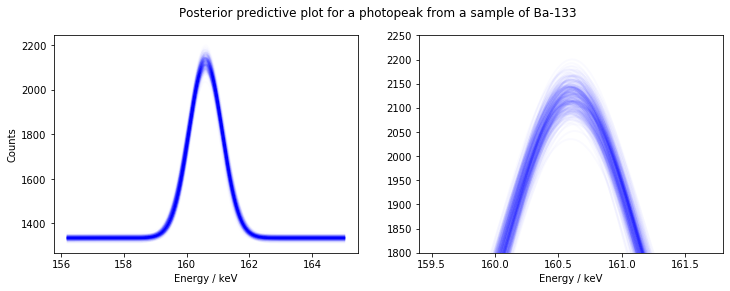

In [18]:
ind = 1
x = peaks_x[ind]
xsmooth = np.linspace(x[0], x[-1], len(x) * 100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
for i in range(n_fits):
    ax1.plot(xsmooth, gauss(xsmooth, a_samps[ind][i], xc_samps[ind][i],
                                  w_samps[ind][i], y0_samps[ind][i]), "b-", alpha=0.01, linewidth=2)
    ax2.plot(xsmooth, gauss(xsmooth, a_samps[ind][i], xc_samps[ind][i],
                                  w_samps[ind][i], y0_samps[ind][i]), "b-", alpha=0.02, linewidth=2)
ax1.set_ylabel("Counts")
ax1.set_xlabel("Energy / keV")

ax2.set_xlim(159.4,161.8)
ax2.set_ylim(1800, 2250)
ax2.set_xlabel("Energy / keV")

fig.suptitle("Posterior predictive plot for a photopeak from a sample of Ba-133")
plt.show()

### Uncertainty on the total counts:

Now that we have a model with the mean fitted parameters for each curve, we can integrate to find the total area under a curve. Using the uncertainty in each parameter from above, the pecentage error in the total counts can be found. This can be used as a nice way to judge the quality of the fit, and whether the curve can be "trusted" to approximate the data. 

Using scipy's "integrate.quad" function makes the integration simple. I'll use the same example peak as perviously, integrating between the bottom of the tails of the peak:

In [19]:
# parameter means and standard deviations of peak
a, a_err = resdict[1]["a_mu"], resdict[1]["a_sig"]
xc, xc_err = resdict[1]["xc_mu"], resdict[1]["xc_sig"]
w, w_err = resdict[1]["w_mu"], resdict[1]["w_sig"]
y0, y0_err = resdict[1]["y0_mu"], resdict[1]["y0_sig"]

# integrate, dividing by the calibration coefficient (to remove keV from the units)
peak_integral = integrate.quad(lambda t: gauss(t, a, xc, w, y0), 159.1, 162.2)[0] / c_0
peak_integral_err = np.sqrt(2 * np.pi * ((w * a_err) ** 2 + (a * w_err) ** 2 )) / c_0

percent_err = 100*peak_integral_err/peak_integral

print("Total counts = {} \u00B1 {} counts \n".format(peak_integral, peak_integral_err) +
      "Percentage error = {}%".format(percent_err))

Total counts = 22923.05649144784 ± 234.72525614249867 counts 
Percentage error = 1.0239701508831087%


This percentage error was found using a Poisson likelihood, as described above. For a comparison, this integration can be repeated for the alternate sampling method, with a normal likelihood. Using the same alternate parameters that were found earlier, run the same integration process as before:

In [20]:
peak_integral_alt = integrate.quad(lambda t: 
                                   gauss(t, a_alt, xc_alt, w_alt, y0_alt), 159.1, 162.2)[0] / c_0
peak_integral_err_alt = np.sqrt(2 * np.pi * 
                                ((w_alt * a_err_alt) ** 2 + (a_alt * w_err_alt) ** 2 )) / c_0

percent_err_alt = 100*peak_integral_err_alt/peak_integral_alt

print("Alternate total counts = {} \u00B1 {} counts \n".format(peak_integral_alt,
                                                               peak_integral_err_alt) +
      "Alternate percentage error = {}%".format(percent_err_alt))

Alternate total counts = 22945.698313309942 ± 209.6825823091359 counts 
Alternate percentage error = 0.9138208802628024%


It appears both methods result in a very simillar pecentage error, even though the alternate method is a little faster on my machine. This validates the theory that using a normal likelihood distribution on this photopeak approximates a Poisson distribution pretty well.

In both cases, a percentage error of around 1% is more than acceptable, in general. Initially, I used a least-squares algorithm to fit curves to this same data set, which produced a percentage error around 1.3%. This leads me to conclude that using an MCMC algorithm was quite successful.